# Notebook pour l'utilisation de BERT en Transfert Learning

### 1 - Importation des données

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("donnees_propres.csv")
#print(data.head())
print(data['Label'].value_counts())
data

Label
culture          223
monde            213
sante            187
meteo            169
societe          163
politique        161
environnement      1
europe             1
sport              1
Name: count, dtype: int64


,Label,Titre
0,culture,Francophonie
1,culture,La rentrée littéraire
2,culture,Balenciaga
3,culture,Théâtre
4,culture,Goscinny
...,...,...
1114,societe,Avortement : le nombre d'interruptions volonta...
1115,societe,Immigration : un tribunal italien invalide la ...
1116,societe,"""J'ai survécu, donc j'ai décidé de vivre et d'..."
1117,societe,Week-end du 11 novembre : des perturbations su...


In [2]:
label_map = {"culture" :  0, "monde": 1, "meteo": 2, "sante": 3, "politique": 4, "societe": 5, "europe": 6, "environnement": 7, "sport": 8}

# Conversion des étiquettes en indices numériques
labels_numeric = [label_map[label] for label in data['Label']]
print(len(labels_numeric))

1119


### 2 - Importation du modèle

In [3]:
from transformers import BertTokenizer

model_name = 'distilbert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
max_len = 128
encodings = tokenizer(data['Titre'].astype(str).tolist(), padding=True, truncation=True, max_length=max_len, return_tensors='pt')

/home/gris/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [4]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=9)

2024-11-27 14:14:50.736504: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 14:14:50.854506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732713290.901401   30821 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732713290.915579   30821 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 14:14:51.046941: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### 3 - Découpage des données

In [5]:
from sklearn.model_selection import train_test_split

train_texts, validation_texts, train_labels, validation_labels = train_test_split(data['Titre'].astype(str).tolist(), labels_numeric, test_size=0.2)

train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt')

validation_encodings = tokenizer(validation_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt')


In [6]:
import torch

train_input_ids = train_encodings['input_ids']
train_attention_masks = train_encodings['attention_mask']
train_labels_tensor = torch.tensor(train_labels)

In [7]:
validation_input_ids = validation_encodings['input_ids']
validation_attention_masks = validation_encodings['attention_mask']
validation_labels_tensor = torch.tensor(validation_labels)


### 4 - Entrainement du modèle

In [8]:
from torch.utils.data import DataLoader, TensorDataset

# Convertir les labels en tensor
train_labels_tensor = torch.tensor(train_labels)
validation_labels_tensor = torch.tensor(validation_labels)

# Créer des TensorDatasets pour l'entraînement et la validation
train_dataset = TensorDataset(
    train_encodings['input_ids'], 
    train_encodings['attention_mask'], 
    train_labels_tensor
)

validation_dataset = TensorDataset(
    validation_encodings['input_ids'], 
    validation_encodings['attention_mask'], 
    validation_labels_tensor
)

# Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=False)


/home/gris/miniforge3/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch [1/10], Train Loss: 1.8448, Validation Loss: 1.6867
Epoch [2/10], Train Loss: 1.7515, Validation Loss: 1.6427
Epoch [3/10], Train Loss: 1.7049, Validation Loss: 1.6500
Epoch [4/10], Train Loss: 1.6008, Validation Loss: 1.4374
Epoch [5/10], Train Loss: 1.3705, Validation Loss: 1.2954
Epoch [6/10], Train Loss: 1.0419, Validation Loss: 1.0584
Epoch [7/10], Train Loss: 0.8108, Validation Loss: 0.9971
Epoch [8/10], Train Loss: 0.5406, Validation Loss: 1.0378
Epoch [9/10], Train Loss: 0.4170, Validation Loss: 1.1543
Epoch [10/10], Train Loss: 0.3040, Validation Loss: 1.1024


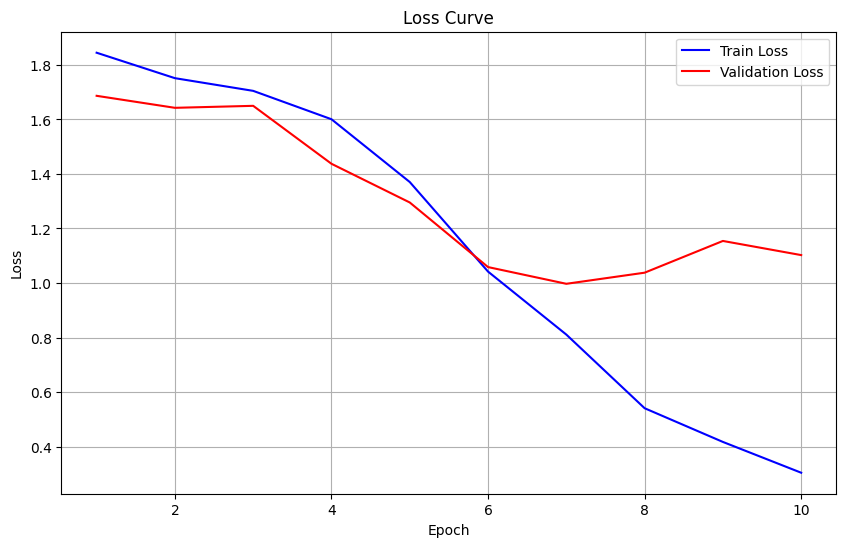

In [9]:
from transformers import AdamW

# Optimiseur
optimizer = AdamW(model.parameters(), lr=1e-5)

# Mode entraînement
model.train()

# Variables pour stocker les pertes
train_losses = []
val_losses = []

# Nombre d'époques
nb_epoch = 10

# Boucle d'entraînement
for epoch in range(nb_epoch):
    # Phase d'entraînement
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        
        # Propagation avant (forward pass)
        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask, 
                        labels=labels)
        
        # La perte est automatiquement calculée par le modèle avec CrossEntropyLoss
        loss = outputs.loss
        
        # Rétropropagation (backpropagation)
        loss.backward()
        
        # Optimisation des paramètres du modèle
        optimizer.step()
        optimizer.zero_grad()
        
        # Ajouter la perte de ce batch à la perte totale
        total_train_loss += loss.item()

    # Calcul de la perte moyenne pour l'entraînement
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Phase de validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():  # Désactive la rétropropagation pour économiser de la mémoire
        for batch in validation_dataloader:
            input_ids, attention_mask, labels = batch
            
            # Propagation avant (forward pass)
            outputs = model(input_ids=input_ids, 
                            attention_mask=attention_mask, 
                            labels=labels)
            
            # La perte de validation
            val_loss = outputs.loss
            total_val_loss += val_loss.item()

    # Calcul de la perte moyenne pour la validation
    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_losses.append(avg_val_loss)
    
    # Affichage de la perte de validation
    print(f"Epoch [{epoch+1}/{nb_epoch}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Affichage des courbes de perte d'entraînement et de validation
plt.figure(figsize=(10, 6))
plt.plot(range(1, nb_epoch + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, nb_epoch + 1), val_losses, label='Validation Loss', color='red')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 5 - Validation du modèle

Validation Loss: 1.1024091626916612


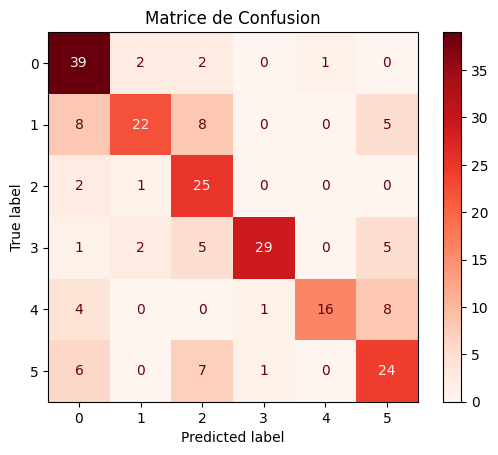

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()

all_predictions = []
all_labels = []

val_loss = 0
for batch in validation_dataloader:
    input_ids, attention_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask, 
                        labels=labels)
        
    val_loss += outputs.loss.item()

    predictions = torch.argmax(outputs.logits, dim=1)
    
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

val_loss = val_loss / len(validation_dataloader)
print(f"Validation Loss: {val_loss}")

# Matrice de confusion
cm = confusion_matrix(all_labels, all_predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm)

display.plot(cmap=plt.cm.Reds)
plt.title("Matrice de Confusion")
plt.show()

In [14]:
# # Mode évaluation
# model.eval()

# # Boucle de validation
# val_loss = 0
# for batch in validation_dataloader:
#     input_ids, attention_mask, labels = batch

#     with torch.no_grad():
#         outputs = model(input_ids=input_ids, 
#                         attention_mask=attention_mask, 
#                         labels=labels)
        
#     # La perte pour la validation
#     val_loss += outputs.loss.item()

#     prediction = torch.argmax(outputs.logits, dim=1)
#     print( "prediction", prediction[0].item(), "label" ,labels[0].item())
# val_loss = val_loss / len(validation_dataloader)
# print(f"Validation Loss: {val_loss}")